In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F
import argparse
import matplotlib
from tqdm import tqdm
import glob
from PIL import Image
import os
from datetime import datetime
import time
import math
import sys
import sys
sys.path.append("../../src")
from ContrastiveModels import *
from visualization import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation = hard_sigmoid
criterion = torch.nn.MSELoss(reduction='none').to(device)
architecture = [784, 500, 10]
alphas_W = [0.5, 0.375]
alphas_M = [-0.01]

model = CSM(architecture, activation, alphas_W, alphas_M)
model = model.to(device)

In [5]:
evaluateEP(model.to(device), test_loader, 20, 0.5, device)

Test accuracy :	 0.1412


0.1412

In [6]:
mbs = train_loader.batch_size
start = time.time()
iter_per_epochs = math.ceil(len(train_loader.dataset)/mbs)
betas = (0.0, 1.0)
beta_1, beta_2 = betas
neural_lr = 0.5

train_acc = [10.0]
test_acc = [10.0]
best = 0.0
epoch_sofar = 0
model.train()

CSM(
  (W): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=10, bias=True)
  )
  (M): ModuleList(
    (0): Linear(in_features=500, out_features=500, bias=False)
  )
  (M_copy): ModuleList(
    (0): Linear(in_features=500, out_features=500, bias=False)
  )
)

In [7]:
trn_acc_list = []
tst_acc_list = []
T1 = 20
T2 = 4
random_sign = True
n_epochs = 30
for epoch_ in range(n_epochs):
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        neurons = model.init_neurons(x.size(0), device)
        neurons = model(x, y, neurons, T1, neural_lr, beta=beta_1, criterion=criterion)
        neurons_1 = copy(neurons)
        if random_sign and (beta_1==0.0):
            rnd_sgn = 2*np.random.randint(2) - 1
            betas = beta_1, rnd_sgn*beta_2
            beta_1, beta_2 = betas
        neurons = model(x, y, neurons, T2, neural_lr, beta = beta_2, criterion=criterion)
        neurons_2 = copy(neurons)
        model.compute_syn_grads(x, y, neurons_1, neurons_2, betas, alphas_M, criterion)
        #optimizer.step()
    trn_acc = evaluateEP(model.to(device), train_loader, 20, neural_lr, device, False)
    tst_acc = evaluateEP(model.to(device), test_loader, 20, neural_lr, device, False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [01:36, 31.12it/s]
2it [00:00, 14.03it/s]

Epoch : 1, Train Accuracy : 0.9602333333333334, Test Accuracy : 0.9558


3000it [03:09, 15.85it/s]
2it [00:00, 15.51it/s]

Epoch : 2, Train Accuracy : 0.9795166666666667, Test Accuracy : 0.972


3000it [02:05, 23.97it/s]
2it [00:00, 13.31it/s]

Epoch : 3, Train Accuracy : 0.9825833333333334, Test Accuracy : 0.9706


3000it [02:03, 24.20it/s]
3it [00:00, 28.15it/s]

Epoch : 4, Train Accuracy : 0.9792333333333333, Test Accuracy : 0.9653


3000it [02:12, 22.71it/s]
3it [00:00, 27.94it/s]

Epoch : 5, Train Accuracy : 0.9879166666666667, Test Accuracy : 0.975


3000it [02:21, 21.16it/s]
2it [00:00, 13.39it/s]

Epoch : 6, Train Accuracy : 0.9879, Test Accuracy : 0.974


3000it [03:19, 15.02it/s]
2it [00:00, 15.04it/s]

Epoch : 7, Train Accuracy : 0.9931166666666666, Test Accuracy : 0.9787


3000it [03:10, 15.76it/s]
2it [00:00, 19.83it/s]

Epoch : 8, Train Accuracy : 0.99095, Test Accuracy : 0.9758


3000it [01:53, 26.53it/s]
2it [00:00, 17.33it/s]

Epoch : 9, Train Accuracy : 0.9955333333333334, Test Accuracy : 0.9777


3000it [02:16, 21.91it/s]
2it [00:00, 17.40it/s]

Epoch : 10, Train Accuracy : 0.9952833333333333, Test Accuracy : 0.9797


3000it [02:26, 20.50it/s]
3it [00:00, 29.71it/s]

Epoch : 11, Train Accuracy : 0.9953666666666666, Test Accuracy : 0.9761


3000it [01:35, 31.37it/s]
3it [00:00, 29.38it/s]

Epoch : 12, Train Accuracy : 0.9950166666666667, Test Accuracy : 0.9785


3000it [01:34, 31.69it/s]
2it [00:00, 17.31it/s]

Epoch : 13, Train Accuracy : 0.9959333333333333, Test Accuracy : 0.9772


3000it [02:47, 17.93it/s]
2it [00:00, 15.78it/s]

Epoch : 14, Train Accuracy : 0.9978333333333333, Test Accuracy : 0.9787


3000it [02:39, 18.80it/s]
2it [00:00, 16.18it/s]

Epoch : 15, Train Accuracy : 0.9982333333333333, Test Accuracy : 0.98


3000it [02:44, 18.23it/s]
2it [00:00, 16.12it/s]

Epoch : 16, Train Accuracy : 0.9981666666666666, Test Accuracy : 0.9808


3000it [02:45, 18.13it/s]


KeyboardInterrupt: 

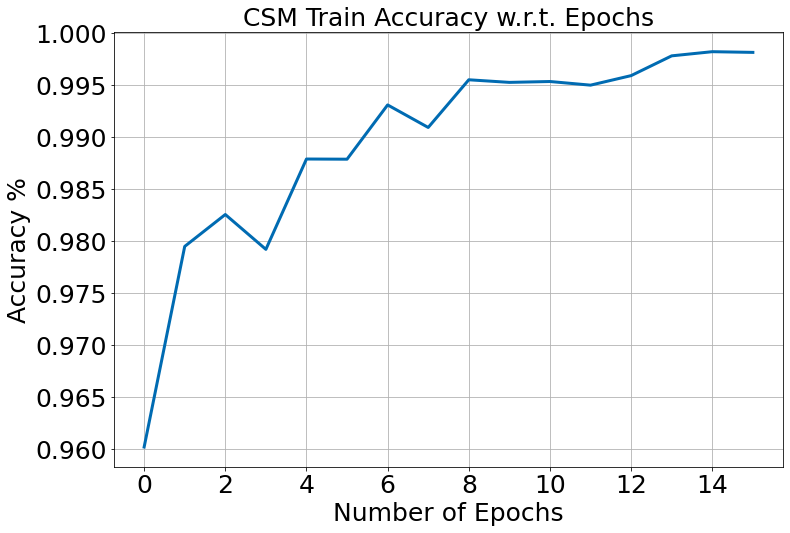

In [8]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'CSM Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

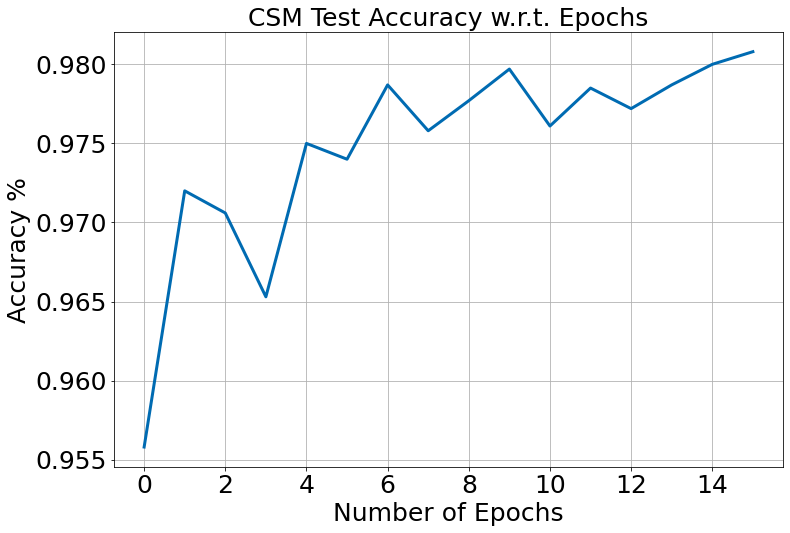

In [9]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'CSM Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)